# Import module, packages

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy import stats

import csv, sqlite3

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

import warnings
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")


# 1. Business Understanding and Analytic Approach

**Objective**: We will analyze real estate prices in major cities such as New York, Los Angeles, and Chicago. The objective is to compare the price differences between these areas and to analyze the factors that influence pricing.  

**Approach**: Focus on collecting data from real estate websites and perform a statistical analysis of prices among different types of properties within the city. The project will involve several steps, including data preprocessing, exploratory data analysis, feature engineering, model training, and evaluation. Techniques such as data cleaning, handling missing values, and encoding categorical variables will be employed to prepare the dataset for model training.


# 2. Data Collection, Understanding, Preparation

### Dataset Collected From Kaggle
https://www.kaggle.com/datasets/ahmedshahriarsakib/usa-real-estate-dataset

### Dataset Dictionary
| **Column Name**     | **Description**                                                                                           | **Data Type**          |
|---------------------|-----------------------------------------------------------------------------------------------------------|------------------------|
| `brokered_by`       | Categorically encoded agency or broker.                                                                    | Categorical            |
| `status`            | Housing status (a. ready for sale, b. ready to build).                                                     | Categorical            |
| `price`             | Housing price (either the current listing price or recently sold price).                                   | Numeric                |
| `bed`               | Number of beds.                                                                                            | Numeric                |
| `bath`              | Number of bathrooms.                                                                                       | Numeric                |
| `acre_lot`          | Property or land size in acres.                                                                            | Numeric                |
| `street`            | Categorically encoded street address.                                                                      | Categorical            |
| `city`              | City name.                                                                                                 | Categorical            |
| `state`             | State name.                                                                                                | Categorical            |
| `zip_code`          | Postal code of the area.                                                                                   | Categorical/Numeric     |
| `house_size`        | House area/size or living space in square feet.                                                             | Numeric                |
| `prev_sold_date`    | Previously sold date.                                                                                      | Date                   |


### Data Segmentation
Due to the instructor's requirements, I would split the dataset into three groups (big cities, tourism cities and outskirts)

In [70]:
big_cities = {
    "Illinois": "Chicago",
    "New York": "New York",
    "California": "Los Angeles"
}

outskirts = {
    "California": "Santa Monica",
    "Connecticut": "Stamford",
    "Virginia": "McLean"
}

tourism_city = {
    "Nevada": "Las Vegas",
    "Florida": "Miami",
    "California": "San Francisco"
}

all = {
    "Illinois": "Chicago",
    "New York": "New York",
    "California": "Los Angeles",
    "California": "Santa Monica",
    "Connecticut": "Stamford",
    "Virginia": "McLean",
    "Nevada": "Las Vegas",
    "Florida": "Miami",
    "California": "San Francisco"
}

In [71]:
raw_df = pd.read_csv(r'C:\Users\LAILE\OneDrive\Máy tính\ADY201m\PythonProject_OnCourse\LAB\LAB3\America\DataSet\realtor-data.zip.csv')

def extract_data(df:pd.DataFrame, loc:dict):
    data_frames = []
    for key, value in loc.items():
        data = df[(df['state'] == key) & (df['city'] == value)]
        data_frames.append(data)
    return pd.concat(data_frames, ignore_index=True)

df_big_cities = extract_data(raw_df, big_cities)
df_outskirts = extract_data(raw_df, outskirts)
df_tourism_city = extract_data(raw_df, tourism_city)
df_all = extract_data(raw_df, all)

# We first analyze big cities
df = df_big_cities

### Data Processing Part 1

In [72]:
df.head()

,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date
0,10387.0,for_sale,1325000.0,5.0,6.0,0.18,1461359.0,Chicago,Illinois,60646.0,5100.0,2008-12-16
1,29307.0,for_sale,374900.0,2.0,2.0,NaN,1423219.0,Chicago,Illinois,60660.0,1600.0,2016-04-14
2,959.0,for_sale,154000.0,1.0,1.0,NaN,466047.0,Chicago,Illinois,60626.0,700.0,NaN
3,92136.0,for_sale,329900.0,3.0,2.0,0.10,1299868.0,Chicago,Illinois,60630.0,967.0,NaN
4,109914.0,for_sale,164900.0,2.0,1.0,NaN,1443877.0,Chicago,Illinois,60660.0,1000.0,2013-04-24


In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32575 entries, 0 to 32574
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   brokered_by     32506 non-null  float64
 1   status          32575 non-null  object 
 2   price           32555 non-null  float64
 3   bed             29818 non-null  float64
 4   bath            30821 non-null  float64
 5   acre_lot        17171 non-null  float64
 6   street          32417 non-null  float64
 7   city            32575 non-null  object 
 8   state           32575 non-null  object 
 9   zip_code        32573 non-null  float64
 10  house_size      23574 non-null  float64
 11  prev_sold_date  25146 non-null  object 
dtypes: float64(8), object(4)
memory usage: 3.0+ MB


In [74]:
df.nunique()

brokered_by        3768
status                2
price              3545
bed                  45
bath                 45
acre_lot            306
street            29797
city                  3
state                 3
zip_code            270
house_size         4137
prev_sold_date     6204
dtype: int64

In [75]:
# Drop Unnecessary Variables
df.drop(['street', 'state', 'prev_sold_date'], axis=1, inplace=True)

Utilizing `zip_code` and `city`, we can remove `street` and `state`.  
And we would not use `prev_sold_date` to analysis.


In [76]:
# Handle missing value
null_count = df.isnull().sum().sort_values()
null_count

status             0
city               0
zip_code           2
price             20
brokered_by       69
bath            1754
bed             2757
house_size      9001
acre_lot       15404
dtype: int64

The data contains numerous null values. Therefore, we will proceed with further analysis to determine the best approach for handling them.

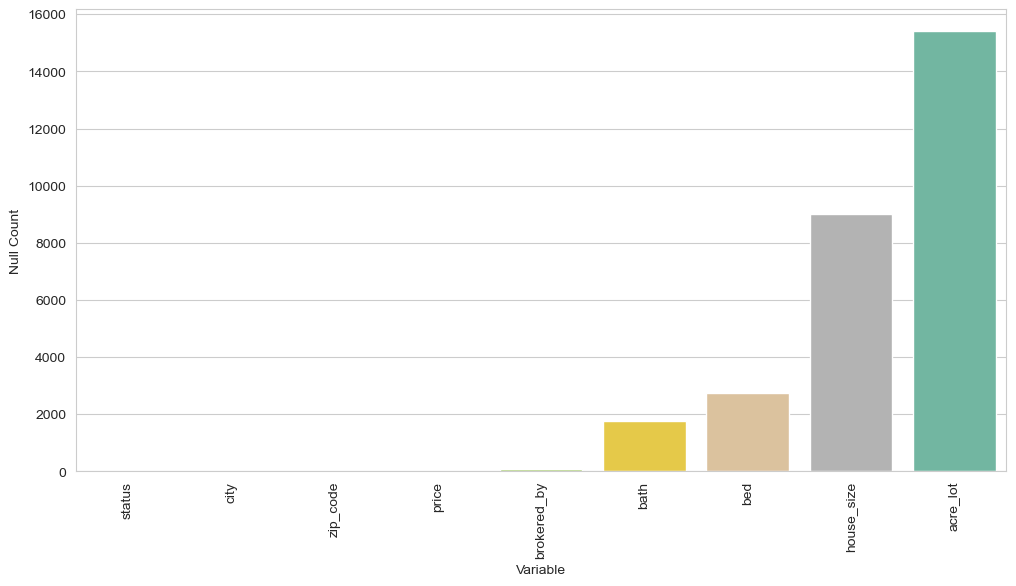

In [77]:
plt.figure(figsize=(12,6))
sns.set_style("whitegrid")
sns.barplot(x=null_count.index, y=null_count, palette="Set2")
plt.xticks(rotation=90)
plt.xlabel('Variable')
plt.ylabel('Null Count');

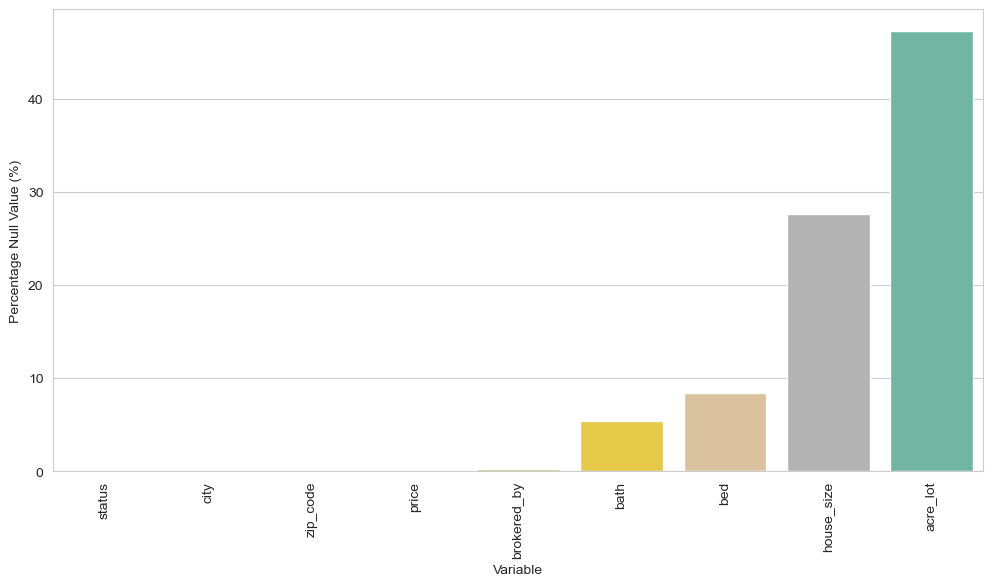

In [78]:
num_of_rows = df.shape[0]
plt.figure(figsize=(12,6))
sns.set_style("whitegrid")
sns.barplot(x=null_count.index, y=(null_count/num_of_rows)*100, palette="Set2")
plt.xticks(rotation=90)
plt.xlabel('Variable')
plt.ylabel('Percentage Null Value (%)');

As we can see, the acre_lot variable has the highest percentage of null values, exceeding 45%. In comparison, house_size has nearly 30% null values, while bed and bath each have under 10%.   

Next, we will compare the distribution of the price variable across the entire dataset with the distribution of price with null values for each variable. This will help us determine whether removing the rows with null values affects the variability of the price variable in the dataset.

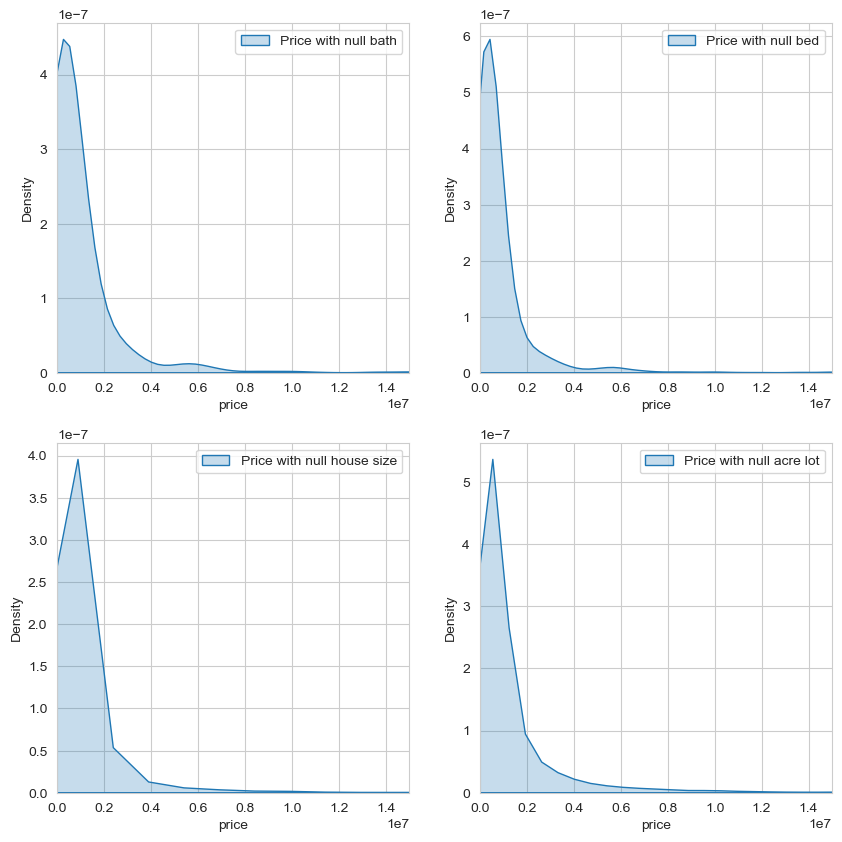

In [79]:

fig, ax = plt.subplots(2,2, figsize=(10,10))
sns.kdeplot(df[np.isnan(df.bath)]['price'], ax=ax[0, 0], fill=True, palette="Set2", label='Price with null bath')
sns.kdeplot(df[np.isnan(df.bed)]['price'], ax=ax[0, 1], fill=True, palette="Set2", label='Price with null bed')
sns.kdeplot(df[np.isnan(df.house_size)]['price'], ax=ax[1, 0], fill=True, palette="Set2", label='Price with null house size')
sns.kdeplot(df[np.isnan(df.acre_lot)]['price'], ax=ax[1, 1], fill=True, palette="Set2", label='Price with null acre lot')

x_limits = (0, 15000000)
for axis in ax.flat:
    axis.set_xlim(x_limits)

for axis in ax.flat:
    axis.legend();

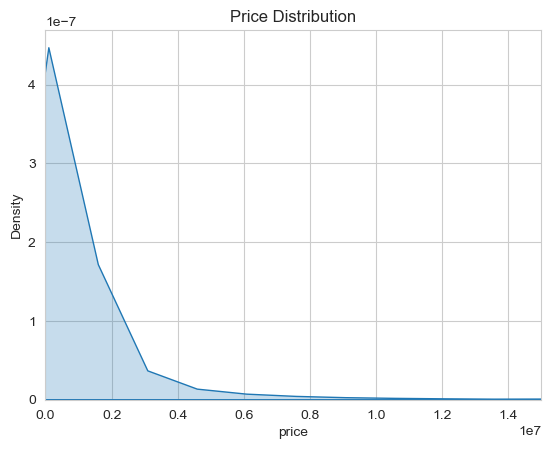

In [80]:
sns.kdeplot(df.price, fill=True, palette="Set2")
plt.title('Price Distribution')
plt.xlim(0,15000000);

Based on the plotted graphs, we observe that the distribution of house prices when the variables contain null values is similar to the overall house price distribution. Therefore, removing these rows will not affect the distribution of house prices. However, for acre_lot and house_size, due to the high percentage of null values, we will consider whether to delete them or not through further analysis steps.

Suppose we drop NaN row to compute the correlations between target variable and other independent variables.


In [81]:
dummy = df.dropna(axis=0)
dummy.drop(['status', 'city'], inplace=True, axis=1)
dummy.corr()['price'].sort_values()

acre_lot      -0.001113
brokered_by   -0.000139
zip_code       0.215658
bed            0.293011
bath           0.469058
house_size     0.659601
price          1.000000
Name: price, dtype: float64

As we can see, the correlations of `acre_lot` and `brokered_by` are close to zero. Therefore, it would be appropriate to drop these two columns.  

In terms of other independent variables, we would drop rows having null values.


In [82]:
df.drop(['acre_lot', 'brokered_by'], axis=1, inplace=True)
df.dropna(inplace=True, axis=0)
df.reset_index(inplace=True, drop=True)

In [83]:
# Adding categorical variable `price_range`
bins = [0, 300000, 700000, 1500000, 5000000, 10000000, 200000000]
labels = ['0-300K', '300K-700K', '700K-1.5M', '1.5M-5M', '5M-10M', '10M-200M']
df['price_range'] = pd.cut(df['price'], bins=bins, labels=labels)

In [84]:
# Data After Processing Part 1
df.head()

,status,price,bed,bath,city,zip_code,house_size,price_range
0,for_sale,1325000.0,5.0,6.0,Chicago,60646.0,5100.0,700K-1.5M
1,for_sale,374900.0,2.0,2.0,Chicago,60660.0,1600.0,300K-700K
2,for_sale,154000.0,1.0,1.0,Chicago,60626.0,700.0,0-300K
3,for_sale,329900.0,3.0,2.0,Chicago,60630.0,967.0,300K-700K
4,for_sale,164900.0,2.0,1.0,Chicago,60660.0,1000.0,0-300K


# 3. Data Analysis with SQL

In [85]:
con = sqlite3.connect("HouseData.db")
cur = con.cursor()

In [86]:
# Activate SQL Magic
%load_ext sql

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [87]:
# Allow SQL Magic connect to CSDL
%sql sqlite:///HouseData.db

In [88]:
# Import DataFrame
df.to_sql('BigCities', con, if_exists='replace', index=False)

22465

In [89]:
# Sample Querry

In [90]:
%%sql
SELECT *
FROM BigCities
where [price] > 100000000;


 * sqlite:///HouseData.db
Done.


status,price,bed,bath,city,zip_code,house_size,price_range
for_sale,135000000.0,5.0,6.0,New York,10022.0,8055.0,10M-200M
for_sale,165000000.0,14.0,27.0,Los Angeles,90024.0,56500.0,10M-200M


Only two houses have price being greater than 100M.

In [91]:
con.close()

# 4. Data Analysis with Python

In the exploratory data analysis, I will analyze the relationship between the target variable and the independent variables. I will also analyze the relationship between the independent variables. This will help me to understand the data better and to find out the variables that have most impact on the target variable.

### Phân tích các giá trị thống kê của biến phụ thuộc `price`

1.	Giá trị trung bình (mean).
2.	Trung vị (median).
3.	Độ lệch chuẩn (std).
4.	Giá trị nhỏ nhất (min).
5.	Giá trị lớn nhất (max).
6.	Phân vị thứ 25% (25% quantile).
7.	Phân vị thứ 75% (75% quantile).

In [92]:
statistic = df.describe()
print("Thống kê mô tả tổng quát cho bất động sản:")
statistic

Thống kê mô tả tổng quát cho bất động sản:


,price,bed,bath,zip_code,house_size
count,2.246500e+04,22465.000000,22465.000000,22465.000000,22465.000000
mean,1.433767e+06,3.114089,2.664500,64503.730336,1997.298108
std,3.493551e+06,2.561013,2.405907,24569.877537,1893.350247
min,7.000000e+03,1.000000,1.000000,10001.000000,375.000000
25%,3.300000e+05,2.000000,2.000000,60612.000000,1100.000000
50%,6.600000e+05,3.000000,2.000000,60640.000000,1500.000000
75%,1.375000e+06,4.000000,3.000000,90022.000000,2292.000000
max,1.650000e+08,70.000000,74.000000,91607.000000,59071.000000


In [93]:
# 8. Độ biến thiên giá theo khu vực
price_variance_by_location = df.groupby('city')['price'].var()
price_variance_by_location

city
Chicago        5.139529e+11
Los Angeles    1.373678e+13
New York       4.668359e+13
Name: price, dtype: float64

In [94]:
# 9. Số lượng bất động sản theo từng khu vực
count_by_province = df['city'].value_counts()
count_by_province

city
Chicago        11874
Los Angeles     7783
New York        2808
Name: count, dtype: int64

In [95]:
# 10. Hệ số biến thiên giá (coefficient of variation)
cv = df['price'].std() / df['price'].mean()
cv

2.4366246983052973

Hệ số biến thiên 243%: Cho thấy mức độ phân tán của giá nhà lớn ở các thành phố lớn tại Mỹ

In [96]:
# 11. Độ lệch trung bình tuyệt đối (mean absolute deviation)
price_data = df['price']
mean_price = price_data.mean()
mad = (price_data - mean_price).abs().mean()

print("Mean Absolute Deviation (MAD):", mad)

Mean Absolute Deviation (MAD): 1328736.686092918


In [97]:
# 12. Độ phân tán của giá (range)
price_range = df['price'].max() - df['price'].min()
price_range

164993000.0

In [98]:
# 13. Phân tích ngoại lệ (outliers) - sử dụng IQR (Interquartile Range)
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df['price'] < (Q1 - 1.5 * IQR)) | (df['price'] > (Q3 + 1.5 * IQR))]
outliers['price_range'].value_counts()

price_range
1.5M-5M      1219
5M-10M        616
10M-200M      332
0-300K          0
300K-700K       0
700K-1.5M       0
Name: count, dtype: int64

In [99]:
# 14. Phân tích tần suất xuất hiện của giá (frequency analysis)
price_frequency = df['price_range'].value_counts()
price_frequency

price_range
300K-700K    6877
700K-1.5M    5642
0-300K       5028
1.5M-5M      3970
5M-10M        616
10M-200M      332
Name: count, dtype: int64

In [100]:
# 15. Hệ số tương quan giữa giá và diện tích bất động sản
corr_price_area = df['price'].corr(df['house_size'])
corr_price_area

0.5689919386148315

Hệ số tương quan ~ 0.56 --> Có một mối quan hệ tương quan nhất định

In [101]:
# 16. Hệ số tương quan giữa giá và số phòng ngủ
corr_price_bedroom = df['price'].corr(df['bed'])
corr_price_bedroom

0.24657085903366047

In [102]:
# 17. Phân tích sự khác biệt giá giữa các vùng (giá trung bình giữa các vùng)
mean_price_by_location = df.groupby('city')['price'].mean()
mean_price_by_location.sort_values(ascending=False)

city
New York       4.030042e+06
Los Angeles    1.874951e+06
Chicago        5.306098e+05
Name: price, dtype: float64

In [103]:
# 18. Đánh giá mức độ phân tán giá
price_dispersion = df['price'].std() / df['price'].mean()
price_dispersion

2.4366246983052973

In [104]:
# 19. Giá trị ngoại lệ trên và dưới (dùng IQR như phần trên)
outliers_upper = df[df['price'] > (Q3 + 1.5 * IQR)]
outliers_lower = df[df['price'] < (Q1 - 1.5 * IQR)]
print(f'Outliers upper: {outliers_upper}')
print(f'Outliers lower: {outliers_lower}')

Outliers upper:          status      price  bed  bath         city  zip_code  house_size  \
718    for_sale  2945000.0  4.0   5.0      Chicago   60610.0      5000.0   
744    for_sale  3650000.0  6.0   8.0      Chicago   60654.0     10000.0   
746    for_sale  3099000.0  3.0   4.0      Chicago   60607.0      3395.0   
934    for_sale  4495000.0  5.0   6.0      Chicago   60611.0      8000.0   
943    for_sale  7650000.0  5.0   6.0      Chicago   60614.0      6400.0   
...         ...        ...  ...   ...          ...       ...         ...   
22433      sold  5125000.0  5.0   6.0  Los Angeles   90046.0      5366.0   
22434      sold  4250000.0  4.0   4.0  Los Angeles   90068.0      3670.0   
22437      sold  2995000.0  4.0   4.0  Los Angeles   90049.0      3270.0   
22441      sold  6795000.0  5.0   5.0  Los Angeles   90027.0      4878.0   
22447      sold  3795000.0  3.0   3.0  Los Angeles   90069.0      2848.0   

      price_range  
718       1.5M-5M  
744       1.5M-5M  
746       1

In [105]:
# 20. Sự phân phối giá qua các phân vị
price_quantiles = df['price'].quantile([0.25, 0.5, 0.75, 1.0])
price_quantiles

0.25       330000.0
0.50       660000.0
0.75      1375000.0
1.00    165000000.0
Name: price, dtype: float64

# 5. Data Visualization

**So sánh số lượng bất động sản tại ba thành phố.**

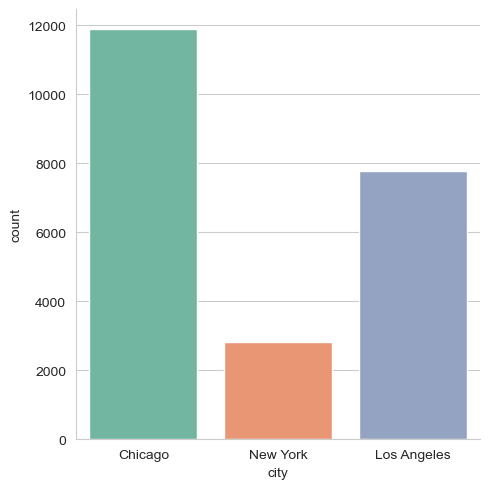

In [106]:
sns.catplot(data=df, x='city',kind='count', palette="Set2");

Nhận xét: Thành phố có số lượng nhà được đăng bán trên Realtor lớn nhất là Chicago với gần 12000, theo sau là Los Angeles với gần 8000 và NewYork khoảng 2800.

-> Điều này có thể ảnh hưởng bởi diện tích của cả ba thành phố, New York (789,4km2), Los Angeles(1290,6 km2), Chicago (19000000km2).  
-> Dân số đông, diện tích lớn thì khả năng cao thị trường số lượng bất động sản sẽ nhiều hơn.

**So sánh giá trung bình giữa các thành phố lớn tại Mỹ**

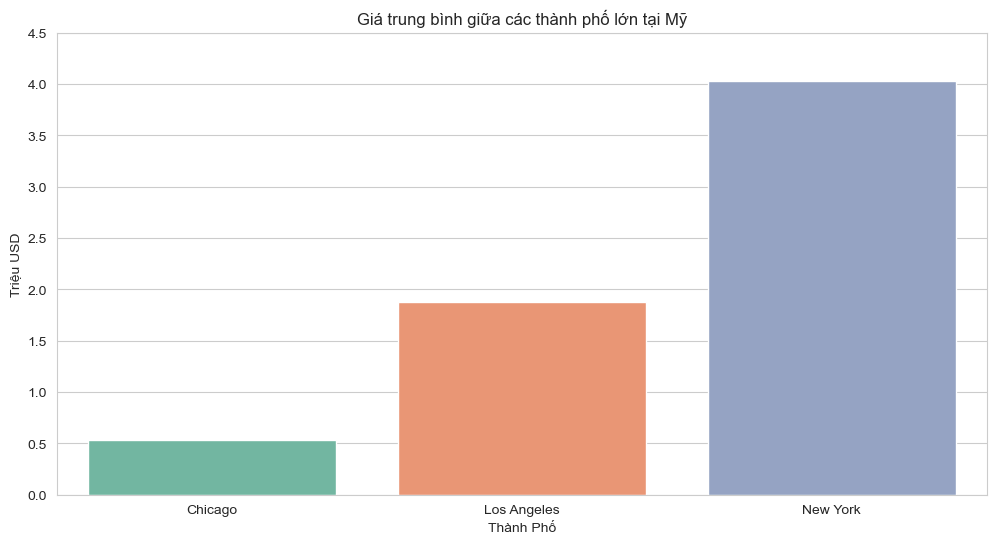

In [107]:
average_province = df.groupby('city')['price'].mean()

plt.figure(figsize=(12,6))
sns.barplot(x=average_province.index, y=average_province.values, palette="Set2")

yticks = plt.yticks()[0]
plt.yticks(yticks, labels=[f'{float(tick)/((10**6)):,.1f}' for tick in yticks])

plt.title('Giá trung bình giữa các thành phố lớn tại Mỹ')
plt.xlabel('Thành Phố')
plt.ylabel('Triệu USD');

Nhận xét: Giá nhà trung bình tại New York rơi vào khoảng 4 triệu dollars, gấp 2 lần giá nhà trung bình tại Los Angeles, gấp 8 lần giá nhà tại Chicago.  

-> Điều này là hệ quả của việc New York là một trong những thành phố có nền kinh tế phát triển bậc nhất thế giới, có nhiều tiện ích, dịch vụ chất lượng cao, đông dân số bậc nhất.  
-> Dẫn đến nhu cầu tìm kiếm và sở hưu chỗ ở của người dân và các doang nghiệp trong và ngoài nước là rất lớn.   
-> Giá nhà tăng gấp nhiều lần các thành phố khác.

**Hiển thị boxplot phân phối giá ở các vùng khác nhau.**

9


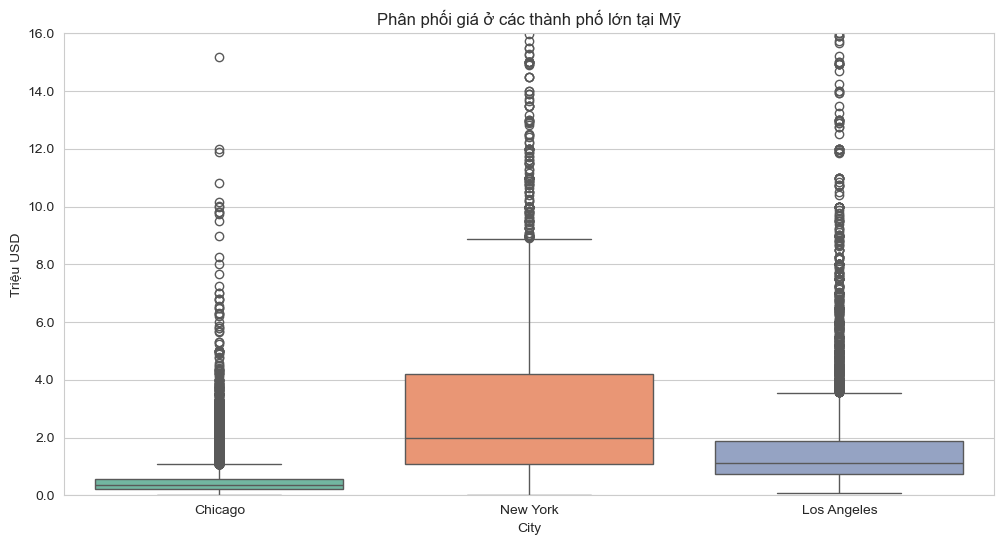

In [108]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='city', y='price', data=df, color='Green', palette="Set2")

plt.ylim(0, 15000000)
yticks = plt.yticks()[0]
print(len(yticks))
plt.yticks(yticks, labels=[f'{float(tick)/(10**6):,.1f}' for tick in yticks])

plt.title('Phân phối giá ở các thành phố lớn tại Mỹ')
plt.xlabel('City')
plt.ylabel('Triệu USD');

Nhận xét: Hầu hết boxplot giá nhà tại ba thành phố đều lệch phải. Lý do có thể là giá càng tăng cao thì số lượng bất đọng có xu hướng chững và giảm xuống.

**Sự thay đổi giá trung bình theo số phòng ngủ của 3 thành phố**

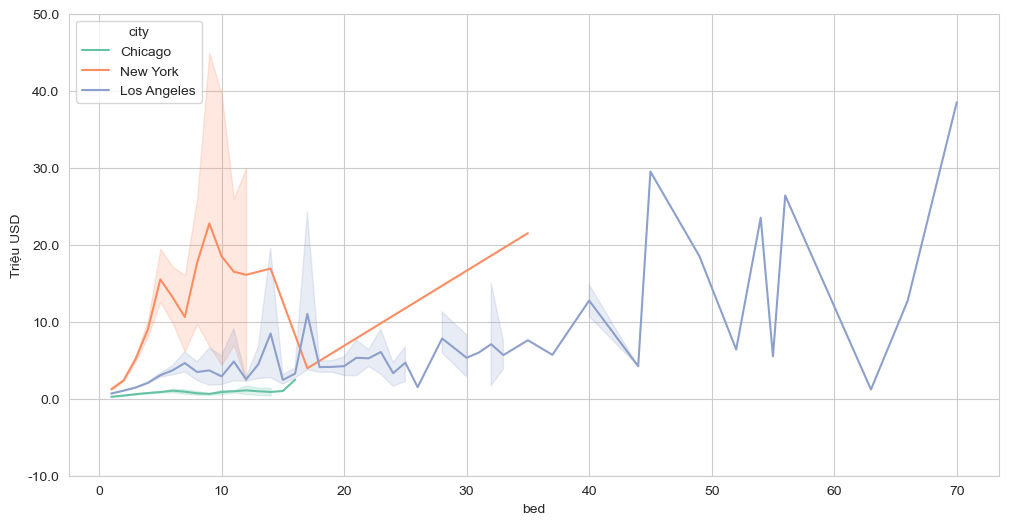

In [109]:
plt.figure(figsize=(12,6))
sns.lineplot(data=df, x='bed', y='price', hue='city', palette="Set2", estimator='mean')
yticks = plt.yticks()[0]
plt.yticks(yticks, labels=[f'{float(tick)/((10**6)):,.1f}' for tick in yticks])
plt.ylabel('Triệu USD');

Nhận xét: (1)Giá nhà trung bình của cả ba thành phố đều có xu hướng tăng lên khi số phòng ngủ tăng lên. (2)Bên cạnh đó, khoảng tin cậy của New York là rộng nhất, theo sau là Los Angeles và hẹp nhất là Chicago. (3)Cuối cùng, Los Angeles và New York có phân bố số lượng phòng ngủ lớn hơn Chicago.   

(1) --> Số phòng ngủ tăng dẫn đến diện tích tăng cao và giá nhà tổng thể tăng cao.   
(2) --> Giá nhà của New York với cùng số lượng phòng ngủ có độ biến thiên rất lớn, có thể lên tới 40M $. Điều này dẫn đến độ chính xác cho giá nhà trung bình của tổng thể thấp hơn Los Angeles và Chicago.    
(3) --> Bởi vì New York và Los Angeles là hai thành phố du lịch nổi tiếng của thế giới với Hollywood Walk of Fame, Tượng Nữ Thần Tự Do, ... , nhu cầu kinh doanh nhà nghỉ, khách sạn tăng cao để phục vụ khách du lịch --> Số lượng phòng ngủ tăng cao.


**Phân tích sự phân tán giá.**

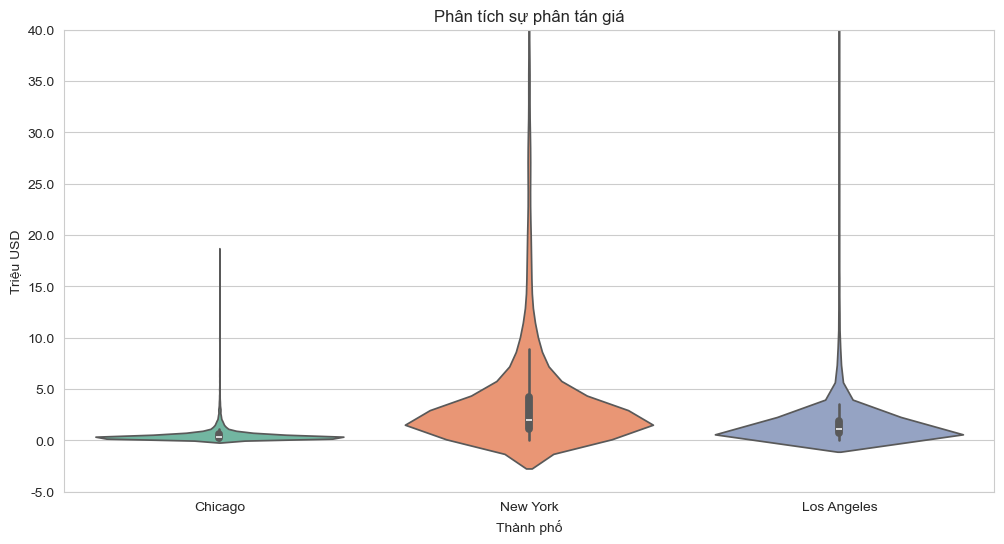

In [110]:
plt.figure(figsize=(12, 6))
sns.violinplot(x='city', y='price', data=df, palette="Set2")

plt.ylim(-1000000, 40000000)
yticks = plt.yticks()[0]
plt.yticks(yticks, labels=[f'{float(tick)/((10**6)):,.1f}' for tick in yticks])

plt.title('Phân tích sự phân tán giá')
plt.xlabel('Thành phố')
plt.ylabel('Triệu USD');


Nhận xét: Đây là biểu đồ kết hợp giứa BoxPlot, biểu đồ KDE. Ta có thể tham khảo để có cái nhìn tổng quát hơn.

**Quan hệ giữa giá và số phòng ngủ.**

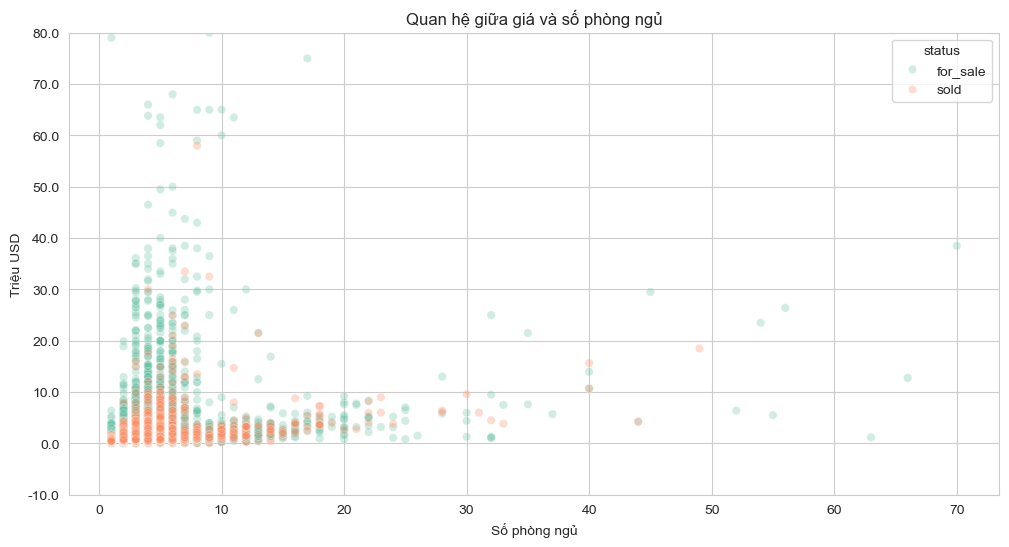

In [111]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='bed', y='price', data=df, alpha=0.3, hue='status', palette="Set2")
plt.ylim(-10000000, 80000000)

yticks = plt.yticks()[0]
plt.yticks(yticks, labels=[f'{float(tick)/(10**6):,.1f}' for tick in yticks])

plt.title('Quan hệ giữa giá và số phòng ngủ')
plt.xlabel('Số phòng ngủ')
plt.ylabel('Triệu USD');

Nhận xét: Giá có độ biến thiên lớn nhất trong khoảng số phòng ngủ dưới 10. Các căn nhà có trạng thái là `for_sale` phần có có giá cao hơn trạng thái `sold` trên cùng một số lượng phòng ngủ.  

--> Hai lý do có thể giải thích cho quan sát này là: (1) giá nhà for_sale có thể được người bán đăng lên với giá cao vì nó còn phải trải qua quá trình thương lượng giữa hai bên để đưa ra một mức giá hợp lí hơn (thấp hơn), và (2) những căn nhà đang được đăng bán đã được cải tạo lại tốt hơn để thu hút người mua, dẫn đến giá trị của căn nhà tăng cao.

**Phân bố số lượng bất động sản theo khu vực.**

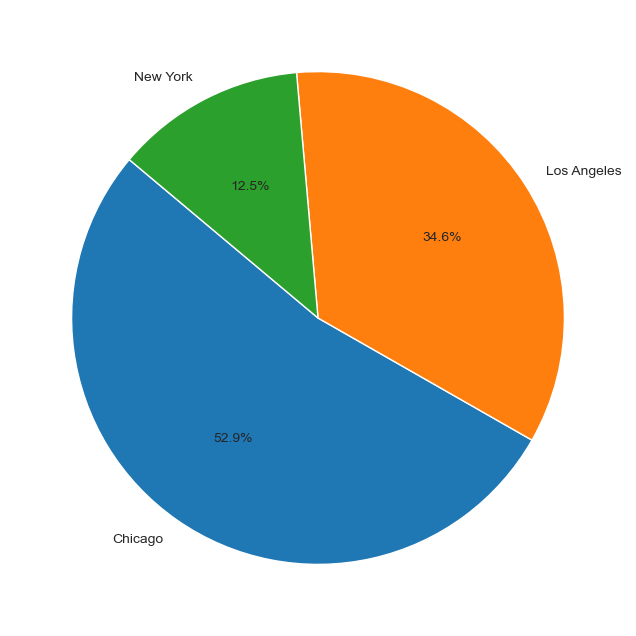

In [112]:
real_estate_counts = df['city'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(real_estate_counts, labels=real_estate_counts.index, autopct='%1.1f%%', startangle=140);

**Phân phối giá của bất động sản.**

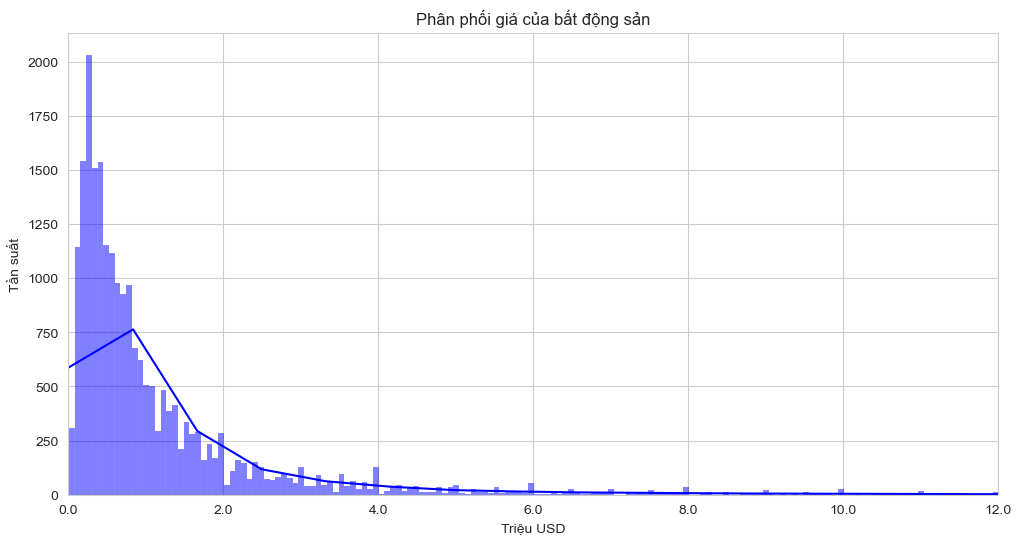

In [113]:
plt.figure(figsize=(12, 6))
sns.histplot(df['price'], kde=True, color='blue', palette="Set2")

plt.xlim(0, 12000000)
xticks = plt.xticks()[0]
plt.xticks(xticks, labels=[f'{float(tick)/(10**6):,.1f}' for tick in xticks])

plt.title('Phân phối giá của bất động sản')
plt.xlabel('Triệu USD')
plt.ylabel('Tần suất');

Nhận xét: Phân phối giá nhà của của cả ba thành phố lệch phải mạnh, mức giá tập trung chủ yếu tại 660K $.

**Phân phối tích lũy giá nhà**

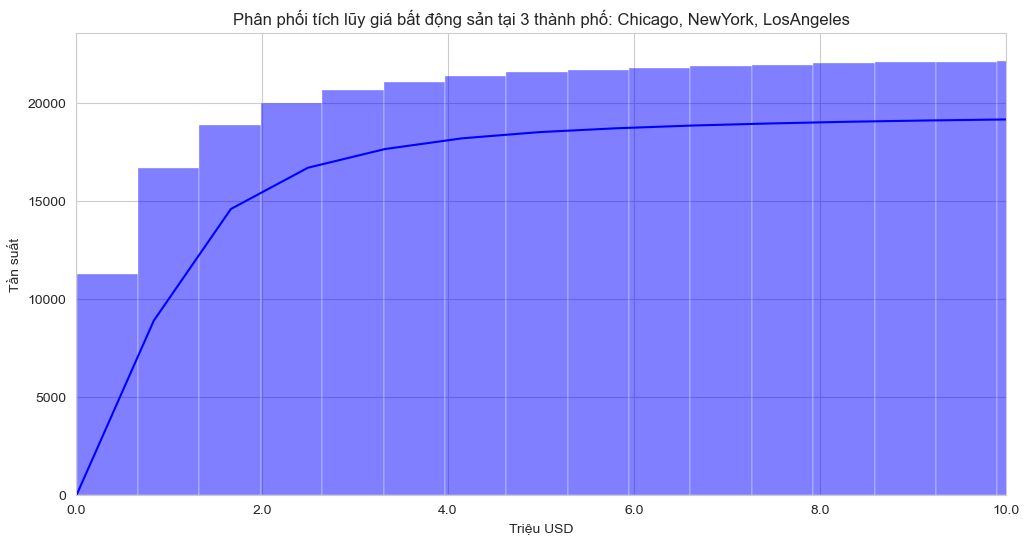

In [114]:
plt.figure(figsize=(12, 6))
sns.histplot(df['price'], kde=True, color='blue', cumulative=True, bins=250, palette="Set2")

plt.xlim(0, 10000000)
xticks = plt.xticks()[0]
plt.xticks(xticks, labels=[f'{float(tick)/(10**6):,.1f}' for tick in xticks])

plt.title('Phân phối tích lũy giá bất động sản tại 3 thành phố: Chicago, NewYork, LosAngeles')
plt.xlabel('Triệu USD')
plt.ylabel('Tần suất');

**Tương quan giữa các biến số khác nhau.**

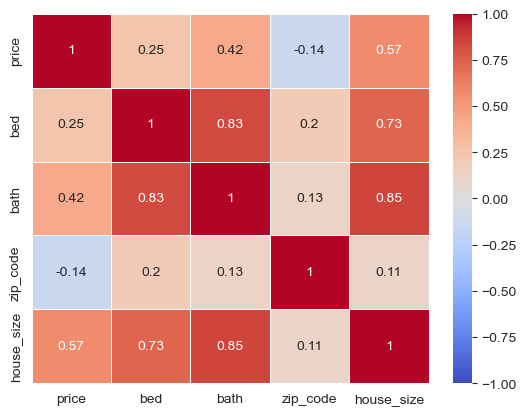

In [115]:
# Tương quan giữa giá và các yếu tố khác.
corr_matrix = df.drop(['status', 'city', 'price_range'], axis=1).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5);

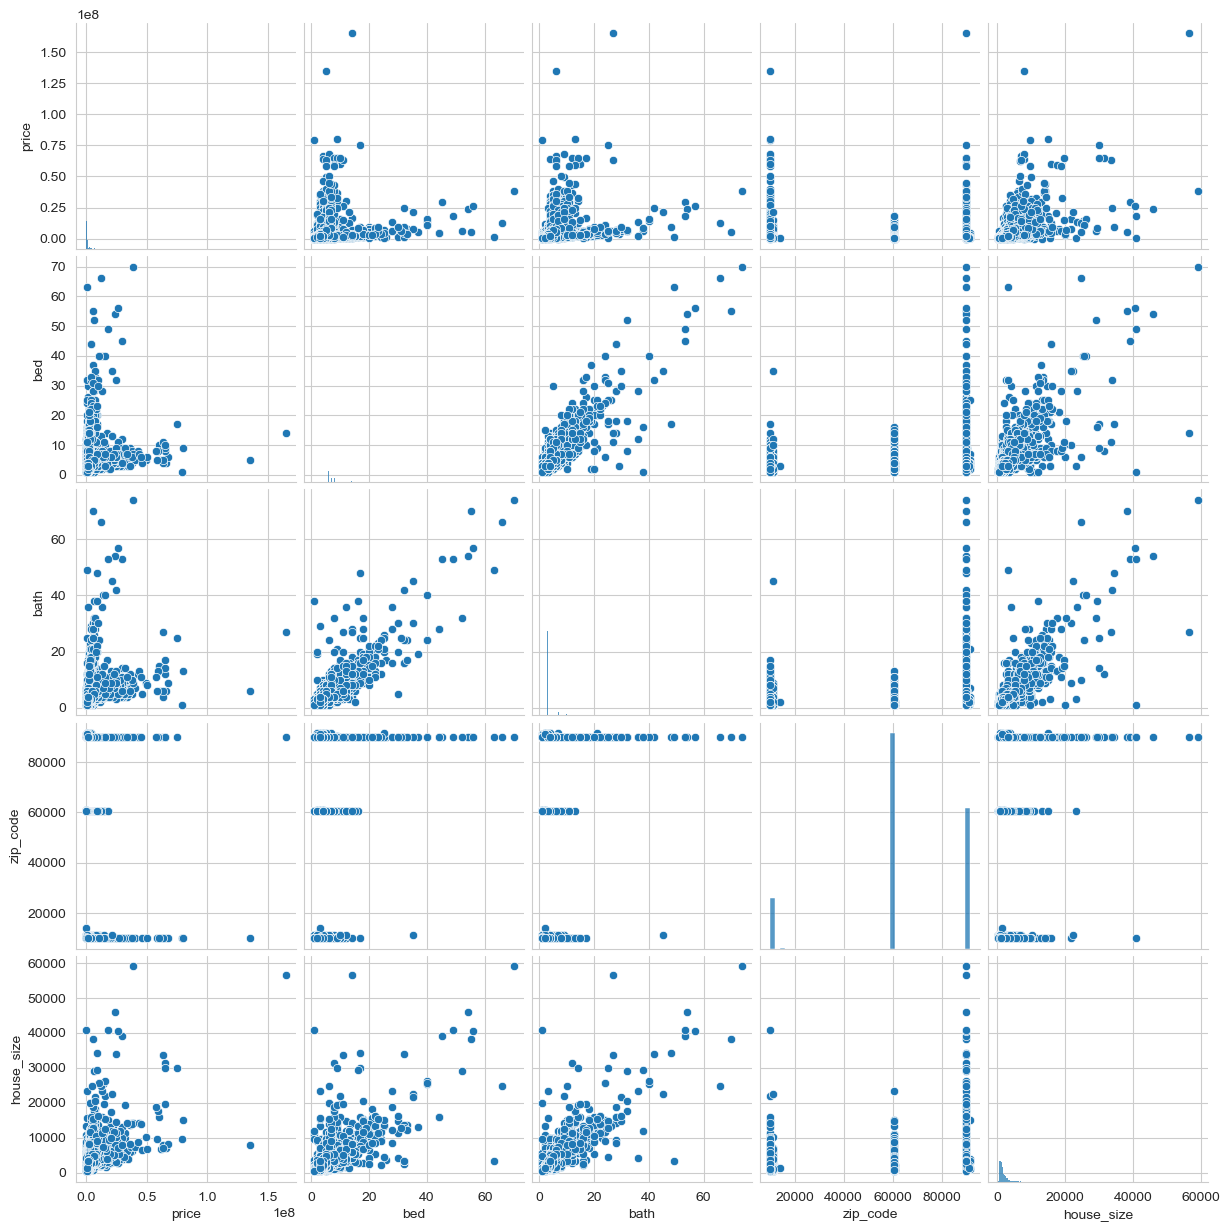

In [116]:
sns.pairplot(df[['price', 'bed', 'bath', 'zip_code', 'house_size']], palette="Set2");

**Biểu đồ mật độ giá**

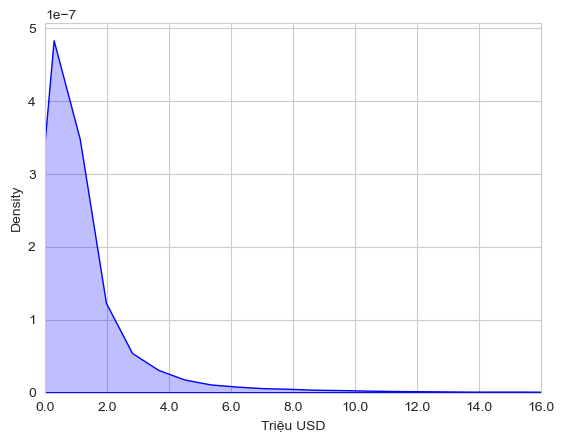

In [117]:
sns.kdeplot(df['price'], color='blue', fill=True, palette="Set2")

plt.xlim(0, 15000000)
xticks = plt.xticks()[0]
plt.xticks(xticks, labels=[f'{float(tick)/((10**6)):,.1f}' for tick in xticks])

plt.xlabel('Triệu USD');

# 8. Regression Analysis

### Data Processing Part 2

In [162]:
# Drop price_range
df_train = df.drop(['price_range'], axis=1)
df_train.dropna(inplace=True, axis=0)

# Encode category variables
df_train['city'] = LabelEncoder().fit_transform(df_train['city'])
df_train['status'] = LabelEncoder().fit_transform(df_train['status'])


# Specify X, Y
X = df_train.drop(['price'], axis=1) 
Y = df_train[['price']]

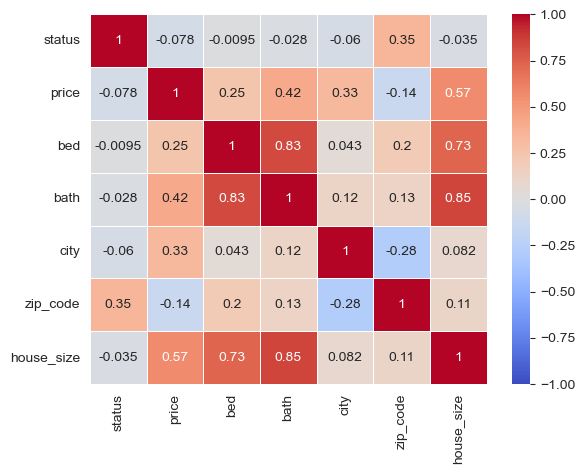

In [163]:
# Draw Corr matrix
corrs = df_train.corr()
sns.heatmap(corrs, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5);

In [164]:
# Train/Test Split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=30)

### Train Model

_Train With Linear Regression Model_

In [165]:
model = LinearRegression()
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
r2_score(Y_test, Y_pred)

0.5190131393070381

_Train With Polynomial Regression Model_

In [166]:
degree = 2  
poly_features = PolynomialFeatures(degree=degree)
X_poly_train = poly_features.fit_transform(X_train)
X_poly_test = poly_features.transform(X_test)

model = LinearRegression()
model.fit(X_poly_train, Y_train)
Y_Ppred = model.predict(X_poly_test)

r2_score(Y_test, Y_Ppred)

0.5511279905490974

_Train With Ridge Regression Model_

In [167]:
alpha = 0.001 
model = Ridge(alpha=alpha)
model.fit(X_train, Y_train)
Y_Rpred = model.predict(X_test)

r2_score(Y_test, Y_Rpred)

0.519013139060496

_Thử nghiệm với Random Forest_

In [168]:
regressor = RandomForestRegressor(n_estimators=100, random_state=0)
regressor.fit(X_train,Y_train)
regressor.score(X_test,Y_test)
Y_Fpred = regressor.predict(X_test)
r2_score(Y_test, Y_Fpred)

0.6206632516758168

### Evaluation 

Text(0.5, 0.98, 'Distribution plot from the models predictions and the actual values')

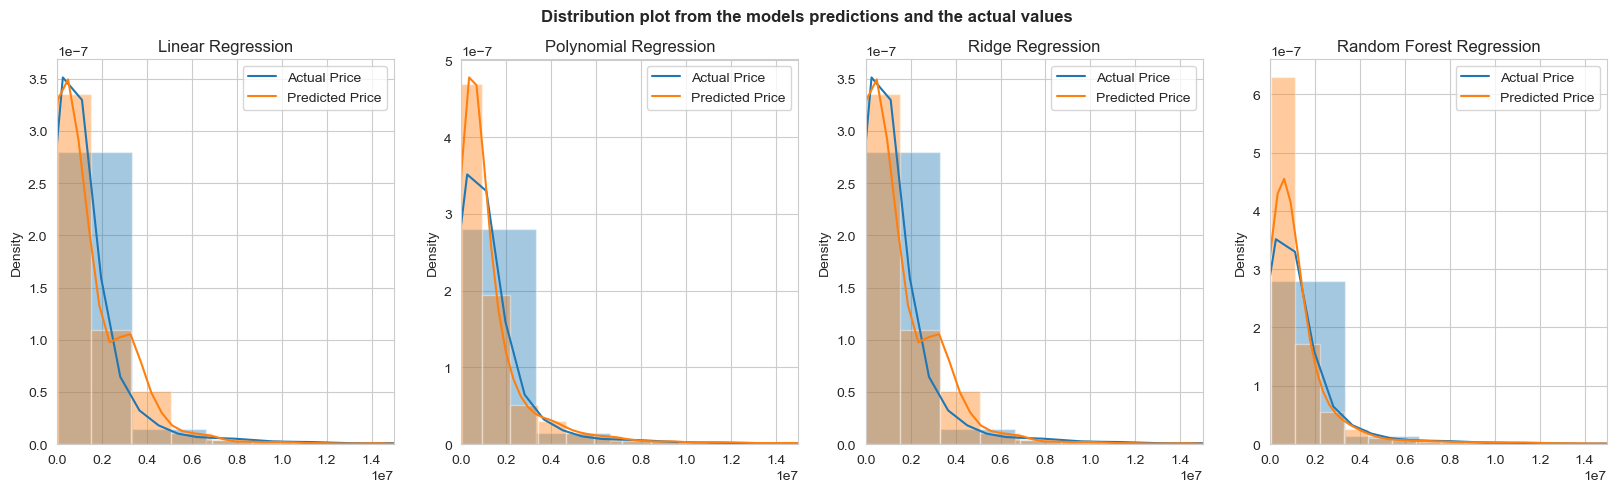

In [169]:
fig, ax = plt.subplots(1,4,figsize=(20,5))
sns.distplot(Y_test,ax=ax[0])
sns.distplot(Y_pred,ax=ax[0])
sns.distplot(Y_test,ax=ax[1])
sns.distplot(Y_Ppred,ax=ax[1])
sns.distplot(Y_test,ax=ax[2])
sns.distplot(Y_Rpred,ax=ax[2])
sns.distplot(Y_test,ax=ax[3])
sns.distplot(Y_Fpred,ax=ax[3])

ax[0].legend(['Actual Price','Predicted Price'])
ax[1].legend(['Actual Price','Predicted Price'])
ax[2].legend(['Actual Price','Predicted Price'])
ax[3].legend(['Actual Price','Predicted Price'])

ax[0].set_title('Linear Regression')
ax[1].set_title('Polynomial Regression')
ax[2].set_title('Ridge Regression')
ax[3].set_title('Random Forest Regression')

x_limits = (0, 15000000)
for axis in ax.flat:
    axis.set_xlim(x_limits)

fig.suptitle("Distribution plot from the models predictions and the actual values", fontweight='bold')

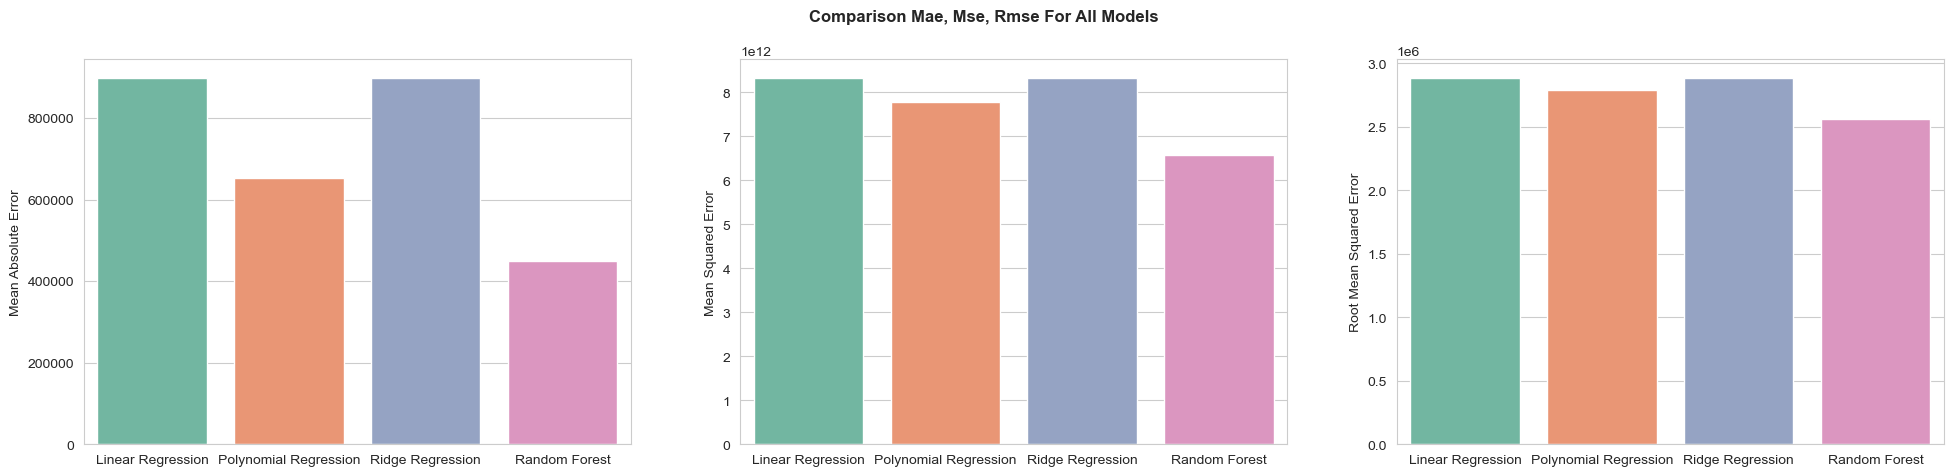

In [170]:
fig, ax = plt.subplots(1,3,figsize=(24,5))
sns.barplot(x=['Linear Regression', 'Polynomial Regression','Ridge Regression','Random Forest'],
            y=[mean_absolute_error(Y_test,Y_pred),mean_absolute_error(Y_test,Y_Ppred),mean_absolute_error(Y_test,Y_Rpred), mean_absolute_error(Y_test,Y_Fpred)], ax=ax[0], palette='Set2')

sns.barplot(x=['Linear Regression', 'Polynomial Regression','Ridge Regression','Random Forest'],
            y=[mean_squared_error(Y_test,Y_pred),mean_squared_error(Y_test,Y_Ppred),mean_squared_error(Y_test,Y_Rpred),mean_squared_error(Y_test,Y_Fpred)],ax=ax[1], palette='Set2')

sns.barplot(x=['Linear Regression', 'Polynomial Regression','Ridge Regression','Random Forest'],
            y=[np.sqrt(mean_squared_error(Y_test,Y_pred)),np.sqrt(mean_squared_error(Y_test,Y_Ppred)),np.sqrt(mean_squared_error(Y_test,Y_Rpred)), np.sqrt(mean_squared_error(Y_test,Y_Fpred))],ax=ax[2], palette='Set2')

ax[0].set_ylabel('Mean Absolute Error')
ax[1].set_ylabel('Mean Squared Error')
ax[2].set_ylabel('Root Mean Squared Error')

fig.suptitle("Comparison Mae, Mse, Rmse For All Models", fontweight='bold');

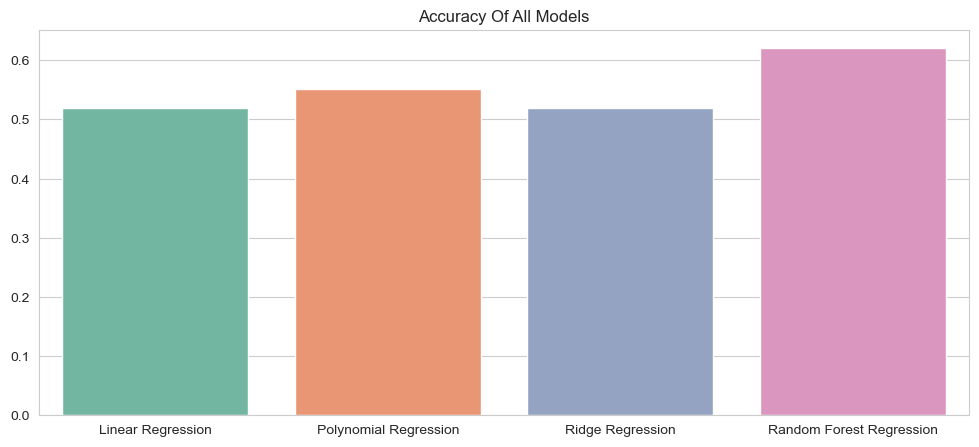

In [171]:
fig, ax = plt.subplots(figsize=(12,5))
sns.barplot(x=['Linear Regression', 'Polynomial Regression', 'Ridge Regression','Random Forest Regression'],y=[r2_score(Y_test,Y_pred), r2_score(Y_test,Y_Ppred), r2_score(Y_test,Y_Rpred), r2_score(Y_test,Y_Fpred)], palette='Set2')
ax.set_title('Accuracy Of All Models');

From the analysis, we can observe that the Random Forest Regression model outperformed the other three models. This could be attributed to the non-linear relationship between the target variable and the independent variables, which the Random Forest Regression model is able to capture more effectively.

# 7. Hypothesis Testing 

#### Giả thuyết 1: Những căn nhà có nhiều phòng ngủ hơn (bed) sẽ có giá cao hơn (price)

Corr: 0.24657085903366044


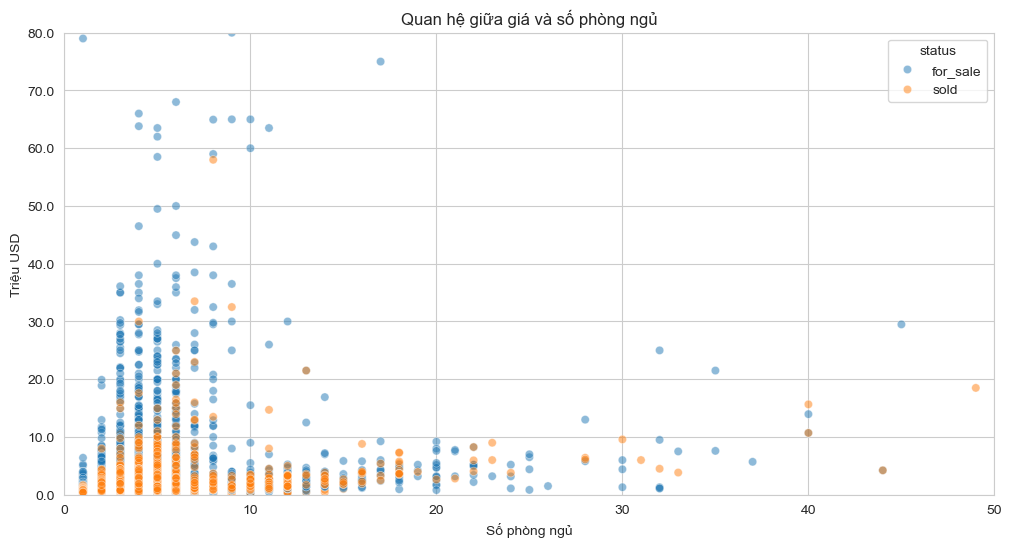

In [172]:
# Tính hệ số tương quan 
corr = df.bed.corr(df.price)
print(f'Corr: {corr}')

# Vẽ biểu đồ scatter
plt.figure(figsize=(12, 6))
sns.scatterplot(x='bed', y='price', hue='status', data=df, alpha=0.5)

plt.xlim(0,50)
plt.ylim(0, 80000000)

yticks = plt.yticks()[0]
plt.yticks(yticks, labels=[f'{float(tick)/(10**6):,.1f}' for tick in yticks])

plt.title('Quan hệ giữa giá và số phòng ngủ')
plt.xlabel('Số phòng ngủ')
plt.ylabel('Triệu USD');

Có một mối quan hệ dương yếu giữa số lượng phòng ngủ và giá của căn nhà, với hệ số tương quan là 0.257. Điều này cho thấy rằng căn nhà có nhiều phòng ngủ hơn có xu hướng có giá cao hơn, nhưng mối quan hệ này không mạnh mẽ.

#### Giả thuyết 2: Những căn nhà có nhiều phòng tắm hơn (bath) sẽ có giá cao hơn (price)

Corr: 0.41503037836855056


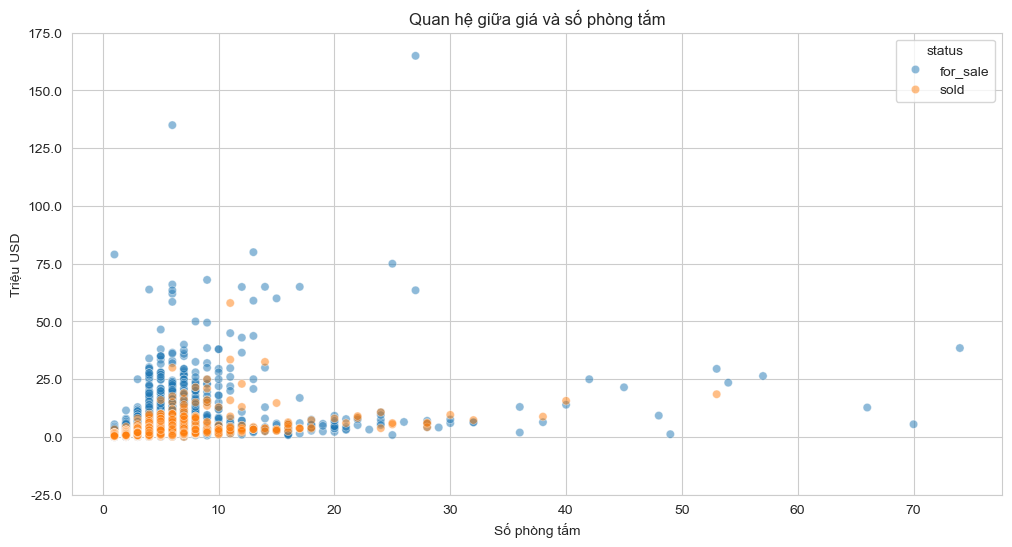

In [173]:
# Tính hệ số tương quan 
corr = df.bath.corr(df.price)
print(f'Corr: {corr}')

# Vẽ biểu đồ scatter
plt.figure(figsize=(12, 6))
sns.scatterplot(x='bath', y='price', hue='status', data=df, alpha=0.5)


yticks = plt.yticks()[0]
plt.yticks(yticks, labels=[f'{float(tick)/(10**6):,.1f}' for tick in yticks])

plt.title('Quan hệ giữa giá và số phòng tắm')
plt.xlabel('Số phòng tắm')
plt.ylabel('Triệu USD');

Có một mối quan hệ dương trung bình giữa số lượng phòng tắm và giá của căn nhà, với hệ số tương quan là 0.415. Điều này cho thấy rằng căn nhà có nhiều phòng tắm hơn có xu hướng có giá cao hơn, và mối quan hệ này có độ mạnh đáng kể.

#### Giả thuyết 3: Diện tích nhà lớn hơn (house_size) sẽ dẫn đến giá nhà cao hơn (price).

Corr: 0.5689919386148315


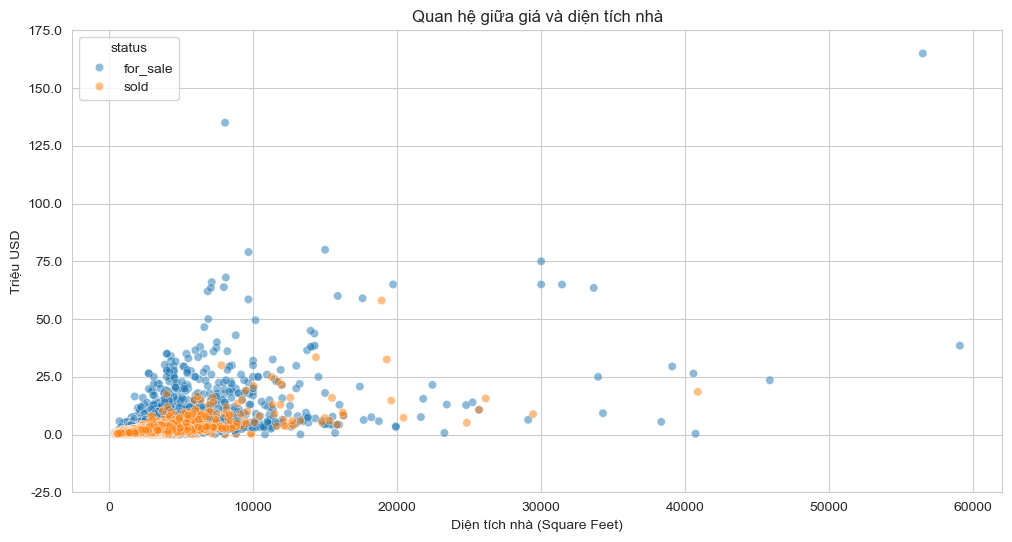

In [174]:
# Tính hệ số tương quan 
corr = df.house_size.corr(df.price)
print(f'Corr: {corr}')

# Vẽ biểu đồ scatter
plt.figure(figsize=(12, 6))
sns.scatterplot(x='house_size', y='price', hue='status',data=df, alpha=0.5)


yticks = plt.yticks()[0]
plt.yticks(yticks, labels=[f'{float(tick)/(10**6):,.1f}' for tick in yticks])

plt.title('Quan hệ giữa giá và diện tích nhà')
plt.xlabel('Diện tích nhà (Square Feet)')
plt.ylabel('Triệu USD');

Có một mối quan hệ dương mạnh giữa diện tích và giá của căn nhà, với hệ số tương quan là 0.56. Điều này cho thấy rằng căn nhà có diện tích lớn hơn có xu hướng có giá cao hơn, và mối quan hệ này có ý nghĩa quan trọng trong việc định giá căn nhà.

####  Giả thuyết 4: Những thành phố khác nhau (state) có mức giá nhà trung bình khác nhau.


f_statistic: [1386.51797267]
p_value: [0.]



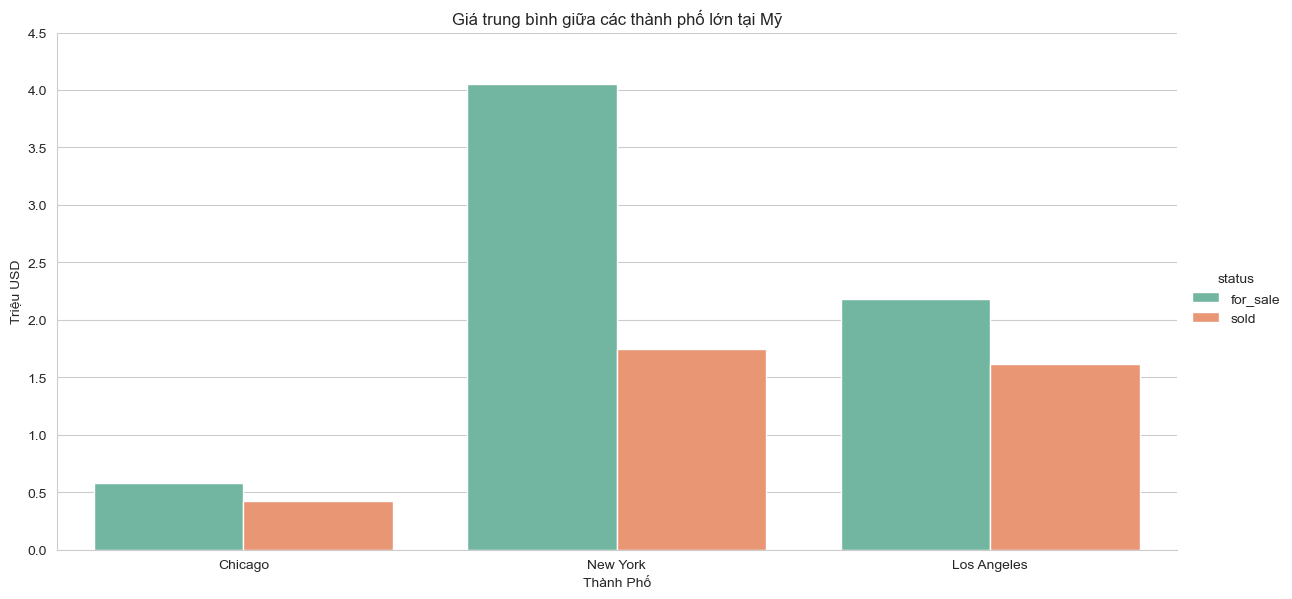

In [175]:
# Sử dụng kiểm định ANOVA
cities = df.city.unique()
group = [df[df['city'] == city][['price']].values for city in cities]
f_statistic, p_value = stats.f_oneway(*group)
print(f'''
f_statistic: {f_statistic}
p_value: {p_value}
''')

# Visualize bằng bar chart
sns.catplot(
    x="city", 
    y="price", 
    hue="status", 
    data=df, 
    kind="bar", 
    height=6, 
    aspect=2, 
    ci=None,
    palette="Set2"
)

yticks = plt.yticks()[0]
plt.yticks(yticks, labels=[f'{float(tick)/((10**6)):,.1f}' for tick in yticks])

plt.title('Giá trung bình giữa các thành phố lớn tại Mỹ')
plt.xlabel('Thành Phố')
plt.ylabel('Triệu USD');

Kết quả của kiểm định ANOVA cho thấy có sự khác biệt đáng kể trong mức giá nhà trung bình giữa các thành phố khác nhau, với F-statistic là 1386 và p-value là 0. Vì giá trị p rất nhỏ nên ta bác bỏ giả thuyết null và chấp nhận rằng ít nhất một thành phố có mức giá nhà trung bình khác biệt so với các thành phố khác.   

Bên cạnh đó biểu đồ cũng cho thấy sự khác biệt rõ rệt giữa giá nhà trung bình của 3 thành phố này, và những căn nhà có trạng thái for_sale thường có giá nhỉnh hơn đã được bán trước đó (đặc biệt là ở new yor, con số tăng hơn nhiều lần)


#### Giả thuyết 5: Những căn nhà ở các thành phố khác nhau (city) có diện tích trung bình khác nhau (house_size).


f_statistic: [303.98974297]
p_value: [5.42051815e-131]



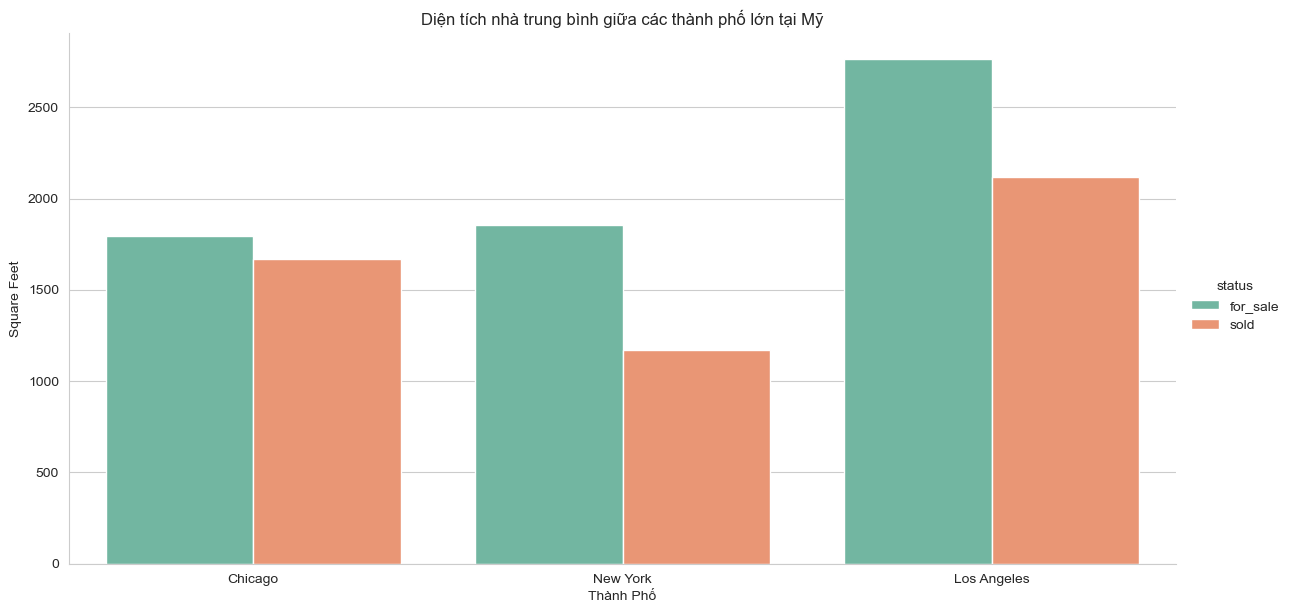

In [176]:
# Sử dụng kiểm định ANOVA
cities = df.city.unique()
group = [df[df['city'] == city][['house_size']].values for city in cities]
f_statistic, p_value = stats.f_oneway(*group)
print(f'''
f_statistic: {f_statistic}
p_value: {p_value}
''')

# Visualize bằng bar chart
sns.catplot(
    x="city", 
    y="house_size", 
    hue='status',
    data=df, 
    kind="bar", 
    height=6, 
    aspect=2, 
    color='Blue', 
    ci=None,
    palette="Set2"
)
plt.title('Diện tích nhà trung bình giữa các thành phố lớn tại Mỹ')
plt.xlabel('Thành Phố')
plt.ylabel('Square Feet');

Kết quả của kiểm định ANOVA cho thấy có sự khác biệt đáng kể trong diện tích trung bình của các căn nhà ở các bang khác nhau, với F-statistic là 304 và p-value là 5.42051815e-131.

Từ biểu đồ này ta có thể thấy những căn nhà for_sale ở new york có diện tích gấp nhiều lần những căn đã được bán, và cũng có thể vì lý do này mà giá nhà ở newyork giữa hai loại status có độ chênh lệch cao như biểu đồ phía trước.


#### Giả thuyết 6: Số lượng trung bình của phòng ngủ và phòng tắm là bằng nhau.


t_value: [19.17716336]
p_value: [1.21891979e-81]



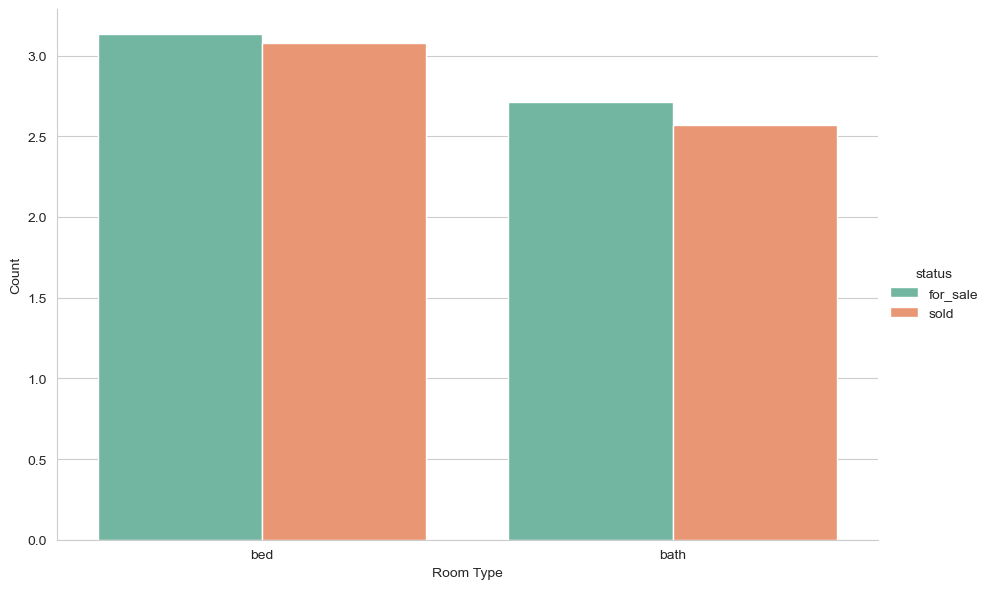

In [177]:
# Sử dụng kiểm định t-test
group = [df[['bed']].values, df[['bath']].values]
t_value, p_value = stats.ttest_ind(*group)
print(f'''
t_value: {t_value}
p_value: {p_value}
''')

# Visualize bằng bar chart
df_melted = pd.melt(df, id_vars=['status'], value_vars=['bed', 'bath'], 
                    var_name='Room Type', value_name='Count')

sns.catplot(
    x="Room Type", 
    y="Count", 
    hue="status", 
    data=df_melted, 
    kind="bar", 
    height=6, 
    aspect=1.5, 
    ci=None,
    palette="Set2"
);

Kết quả của kiểm định t-test cho thấy có sự khác biệt đáng kể giữa số lượng trung bình của phòng ngủ và phòng tắm, với t-value là 19.17716336 và p-value là 1.21891979e-81. Vì giá trị p rất nhỏ nên ta bác bỏ giả thuyết null và kết luận rằng số lượng trung bình của phòng ngủ và phòng tắm có sự khác biệt.

# 8. Plot All Processed Cities On Map

In [178]:
import geopandas as gpd
from matplotlib.ticker import FuncFormatter

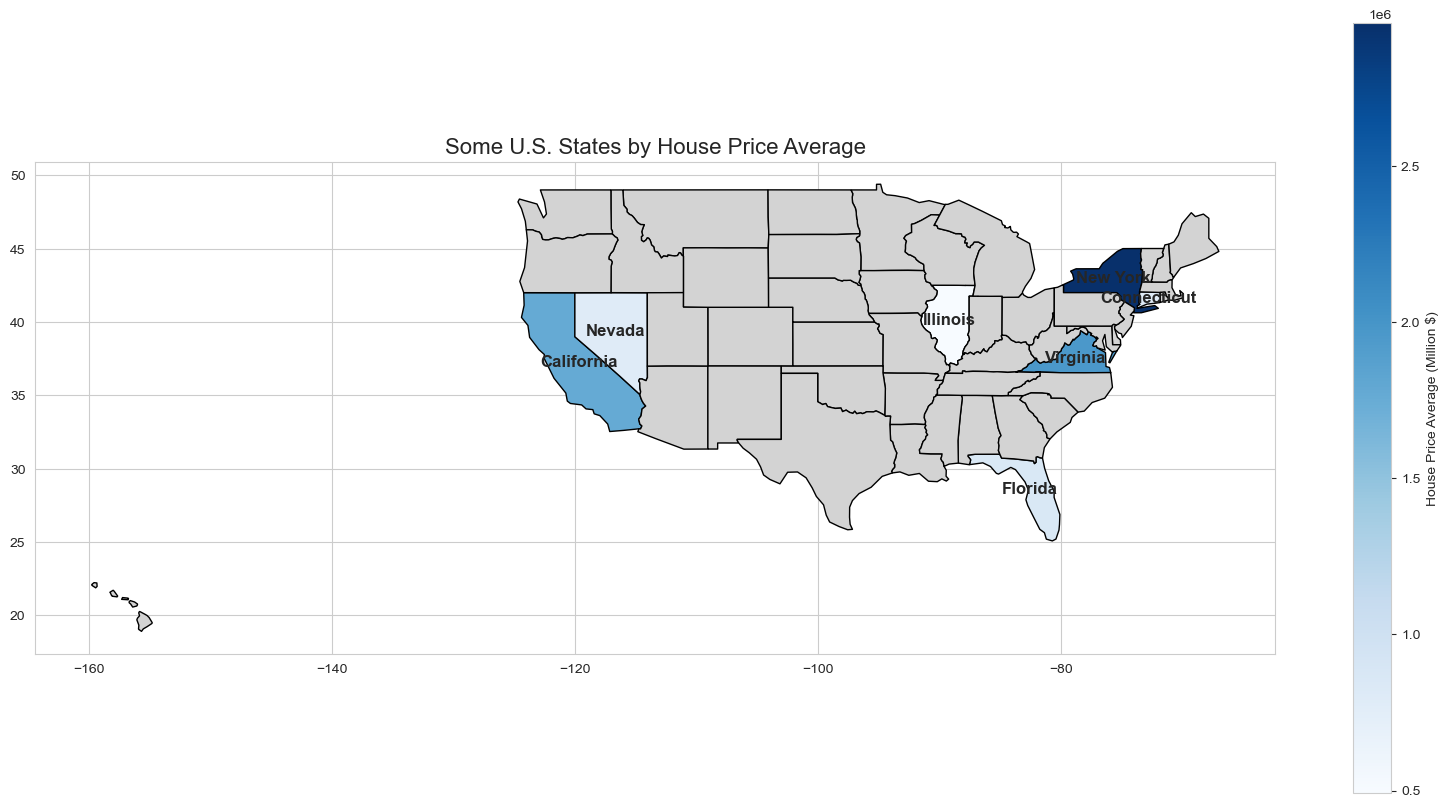

In [179]:
# 1. Đọc dữ liệu shapefile của các bang Mỹ
usa_states = gpd.read_file(r"C:\Users\LAILE\OneDrive\Máy tính\ADY201m\PythonProject_OnCourse\LAB\LAB3\America\DataSet\ne_110m_admin_1_states_provinces\ne_110m_admin_1_states_provinces.shp")  

# 2. Tạo dataframe
price_df = df_all.groupby('state').agg({'price': 'mean'}).reset_index()

# 3. Kết hợp dữ liệu dân số với dữ liệu hình dạng các bang
usa_states = usa_states[usa_states.name != 'Alaska']
usa_states = usa_states.merge(price_df, left_on="name", right_on="state", how='left')

# 4. Vẽ bản đồ
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

# Sử dụng cột 'density' để điều chỉnh độ đậm nhạt của màu sắc, sử dụng missing_kwds nếu muốn vẽ những bang khác
cmap = usa_states.plot(column='price', ax=ax, legend=True,
                legend_kwds={'label': "House Price Average (Million $)",
                             'orientation': "vertical"},
                missing_kwds={
                           'color': 'lightgrey',
                           'label': 'Missing values'
                       },
                cmap='Blues', edgecolor='black'
                )

# Thêm tên các bang
for x, y, label, price in zip(usa_states.geometry.centroid.x, usa_states.geometry.centroid.y, usa_states['state'], usa_states['price']):
    if not pd.isna(price):
        ax.text(x, y, label, fontsize=12, ha='center', va='center', weight='bold')

plt.title("Some U.S. States by House Price Average", fontsize=16);

Remark: This is not a accurate map of US.

In [183]:
df.to_csv('BigCities.csv', index=False)

In [182]:
df

,status,price,bed,bath,city,zip_code,house_size,price_range
0,for_sale,1325000.0,5.0,6.0,Chicago,60646.0,5100.0,700K-1.5M
1,for_sale,374900.0,2.0,2.0,Chicago,60660.0,1600.0,300K-700K
2,for_sale,154000.0,1.0,1.0,Chicago,60626.0,700.0,0-300K
3,for_sale,329900.0,3.0,2.0,Chicago,60630.0,967.0,300K-700K
4,for_sale,164900.0,2.0,1.0,Chicago,60660.0,1000.0,0-300K
...,...,...,...,...,...,...,...,...
22460,sold,1650000.0,2.0,3.0,Los Angeles,90049.0,2718.0,1.5M-5M
22461,sold,1950000.0,4.0,3.0,Los Angeles,90077.0,2299.0,1.5M-5M
22462,sold,1979000.0,3.0,3.0,Los Angeles,90077.0,2543.0,1.5M-5M
22463,sold,749999.0,3.0,2.0,Los Angeles,91335.0,1456.0,700K-1.5M
